In [1]:
## this is for high resolution plot
#%matplotlib inline
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')

import matplotlib.pyplot as plt

import pandas as pd
import scipy.stats
import math

opt = {
    "scpcyc06-output.txt"  : 60,
    "scpsts81-output.txt"  : 61,
    "scpsts135-output.txt" : 103,
}
toplot = "scpcyc06-output.txt"

frame = pd.read_csv(toplot, sep=" ", 
                    names=["seed", "algo", "param", "sol", "feas", 
                           "iter2best", "time2best", "totaltime"])
frame.head()

seed       algo  param  sol    feas  iter2best  time2best  totaltime
0  147085  (1+1)-eah    1.1   62    feas    1120234      5.560    992.566
1  109934  (1+1)-eah    1.2   61    feas     529200      2.784   1052.118
2  109934  (1+1)-eah    1.3   63  infeas     145266      0.797   1097.073
3  176666  (1+1)-eah    1.3   61    feas     353776      1.976   1116.816
4   21207  (1+1)-eah    1.3   62    feas      77049      0.432   1122.106

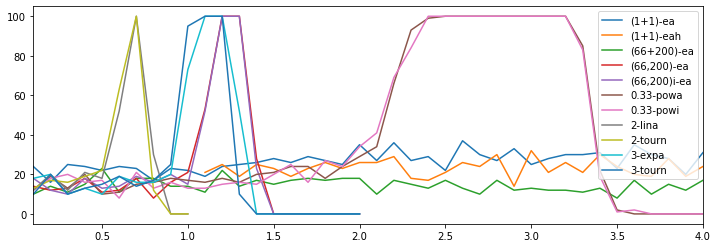

In [2]:
success, total = {}, {}
lstAlgo=sorted(pd.unique(frame["algo"]))

for algo in lstAlgo:
    success[algo], total[algo] = {}, {}
    lstParam = sorted(pd.unique(frame.loc[frame["algo"]==algo]["param"]))
    
    for param in lstParam:
        conf = frame.loc[(frame["algo"]==algo) & (frame["param"]==param)]
        stat = conf["sol"].value_counts()
        
        success[algo][param] = stat[opt[toplot]] if opt[toplot] in stat else 0
        total[algo][param] = len(conf.index)
    
pd.DataFrame(success).plot(figsize=(12,4)) # rugged if the experiments have not completed

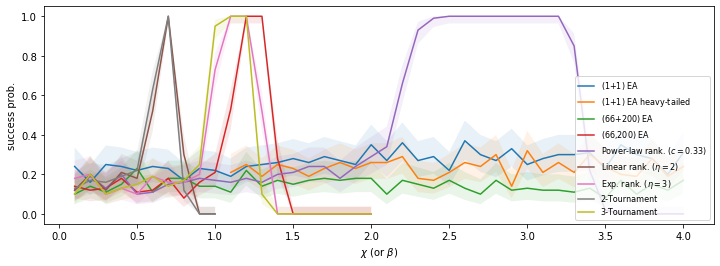

In [3]:
# confidence interval for bernoulli trials
def clopper_pearson(x, n, alpha=0.05):
    lo = scipy.stats.beta.ppf(alpha / 2, x, n - x + 1)
    hi = scipy.stats.beta.ppf(1 - alpha / 2, x + 1, n - x)
    return 0.0 if math.isnan(lo) else lo, 1.0 if math.isnan(hi) else hi

# unique algos
plotAlgo = {"(1+1)-ea"   : r"($1$+$1$) EA", 
            "(1+1)-eah"  : r"($1$+$1$) EA heavy-tailed", 
            "(66+200)-ea": r"($66$+$200$) EA",
            "(66,200)-ea": r"($66$,$200$) EA",
            "0.33-powa"  : r"Power-law rank. ($c=0.33$)",
            "2-lina"     : r"Linear rank. ($\eta=2$)",
            "3-expa"     : r"Exp. rank. ($\eta=3$)",
            "2-tourn"    : r"2-Tournament",
            "3-tourn"    : r"3-Tournament"}

fig = plt.figure(figsize=(12,4))
ax = plt.subplot(111)
for algo in plotAlgo.keys():
    param = list(success[algo].keys()) 
    prob = [success[algo][p]/total[algo][p] for p in param]
    ci = list(zip(*[clopper_pearson(success[algo][p],total[algo][p]) for p in param]))
    ax.fill_between(param, ci[0], ci[1], alpha=0.1)
    ax.plot(param, prob, label=plotAlgo[algo])
ax.set_ylabel("success prob.")
ax.set_xlabel(r"$\chi$ (or $\beta$)")
ax.legend(loc="lower right", prop={'size': 8})

END